In [75]:
from __future__ import division
%pylab inline
from angles import r2d, r2arcs, d2arcs
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr, healpy as hp
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 18,12
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from collections import defaultdict
sns.set_context('talk')

class ModelErrors():
    
    def __init__(self,ModelType,WorstCase):
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.PSF.TrM = self.TrM
        self.STAR.TrM = self.TrM
        self.alpha = None 
        self.ModelType = ModelType
        self.survey_area = (np.radians(200),np.radians(50)) # in radians
        stars_X = np.random.rand(int(1000))*self.survey_area[0] 
        stars_Y = np.random.rand(int(1000))*self.survey_area[1] - self.survey_area[1]
        stars = np.array((stars_X,stars_Y))
        self.stars = stars.swapaxes(1,0)
        self.DELTA.e = defaultdict(float)
        self.DELTA.M = defaultdict(float)
        self.STAR.M = defaultdict(list)
        self.PSF.M = defaultdict(list)
        self.PSF.e = defaultdict(list)
        self.WorstCase = WorstCase
        
    class PSF:
        '''empty class to organise results into
        '''
        pass
    
    class STAR:
        '''empty class to organise results into
        '''
        pass
    
    class DELTA:
        '''empty class to organise results into
        '''
        pass

    def getModels(self):
        '''calls one of the model methods to create an overly simplified model, 
        or (N/A yet) imports one
        '''
        if self.WorstCase==False:
            for i in range(len(self.positions)):
                self.radial_pattern(position_num=i)
        else:
            for i in range(len(self.positions)):
                self.WorstCase_radial(position_num=i)
    def getPositions(self,sqlWhere,database='/Users/myhome/Downloads/minion_1016_sqlite.db'):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere'''
        opsdb = db.OpsimDatabase(database)
        pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
        pos = np.array(pos)
        if any(row[1] == x for row in pos):
            posRA = zip(*pos)[1]
        if any(row[2] == x for row in pos):
            posDec = zip(*pos)[2]
        pos = np.array((posRA,posDec))
        self.positions = pos.swapaxes(1,0)
        
    def avgOver(self):
        ''' averages the shapes in 2nd moment-space 
        '''
        for pos in self.PSF.M.keys(): 
            try:
                self.DELTA.M[pos] = (np.mean(self.STAR.M[pos][0])-np.mean(self.PSF.M[pos][0]),\
                                 np.mean(self.STAR.M[pos][1])-np.mean(self.PSF.M[pos][1]),\
                                 np.mean(self.STAR.M[pos][2])-np.mean(self.PSF.M[pos][2])\
                                )
            except:
                pass
        for i in self.PSF.e.keys():
            try:
                self.PSF.e[i] = (np.mean(self.PSF.M[pos][0]), np.mean(self.PSF.M[pos][1]))
            except:
                pass
            
    def M2e(self):
        for pos in self.DELTA.M.keys():
            Mxx, Mxy, Myy = self.DELTA.M[pos]
            self.DELTA.e[pos] = ((Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM)
    
    def process(self,sqlWhere):
        ''' runs all analysis methods 
        '''
        self.getPositions(sqlWhere)
        self.getModels()
        self.avgOver()
        self.M2e()
        self.getRhos()
        #self.rhos2errors()
        
        
    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.
        '''
        X = [key[0] for key in self.DELTA.e.keys()]
        Y = [key[1] for key in self.DELTA.e.keys()]
        de1 = [val[0] for val in self.DELTA.e.values()]
        de2 = [val[1] for val in self.DELTA.e.values()]
        psfe1 = [val[0] for val in self.PSF.e.values()]
        psfe2 = [val[1] for val in self.PSF.e.values()]
        decat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        psfcat = treecorr.Catalog(g1=psfe1, g2=psfe2, ra=X, dec=Y, ra_units='radians', dec_units='radians')

        dedecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        dedecorr.process(decat)
        dede_xip = dedecorr.xip
        dede_xim = dedecorr.xim
        self.rho1_sigma = dedecorr.varxi**0.5
        self.r = np.exp(dedecorr.meanlogr)
        self.rho1 = dede_xip
        self.rho1_im = dede_xim
        

        edecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        edecorr.process(psfcat, decat)
        ede_xip = edecorr.xip
        ede_xim = edecorr.xim
        
        self.rho2 = ede_xip
        self.rho2_im = ede_xim
        self.rho2_sigma = edecorr.varxi**0.5
        
        self.size_error_ratio = 0.01

        edtedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        edtedtcorr.process(psfcat*self.size_error_ratio, psfcat*self.size_error_ratio)
        edtedt_xip = edtedtcorr.xip
        edtedt_xim = edtedtcorr.xim
        
        self.rho3 = edtedt_xip
        self.rho3_im = edtedt_xim
        
        deedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        deedtcorr.process(decat, psfcat*self.size_error_ratio)
        deedt_xip = deedtcorr.xip
        deedt_xim = deedtcorr.xim
        
        self.rho4 = deedt_xip
        self.rho4_im = deedt_xim
        
        eedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        eedtcorr.process(psfcat, psfcat*self.size_error_ratio)
        eedt_xip = eedtcorr.xip
        eedt_xim = eedtcorr.xim
        
        self.rho5 = eedt_xip
        self.rho5_im = eedt_xim
            
            
    def rhos2errors(self):
        ''' propagates rho statistics into shear errors 
        '''
        self.delta_xip = 2 * (self.delta_T_psf/self.T_gal) * self.xip\
                    + (self.T_PSF/self.T_gal)**2 * rho1\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho2\
                    + (self.T_PSF/self.T_gal)**2 * self.rho3\
                    + (self.T_PSF/self.T_gal)**2 * self.rho4\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho5
                    
    def radial_pattern(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin
        '''
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        try:
            rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        except ZeroDivisionError: 
            return
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)
        stare2 = r*np.sin(2*theta)
        psfe1 = stare1/1.1
        psfe2 = stare2/1.1
        #for i in range(len(e1)):
        #    self.STAR.e[(stars[i][0],stars[i][1])].append((e1[i],e2[i]))
        #    self.PSF.e[(stars[i][0],stars[i][1])].append((e1[i]/1.1,e2[i]/1.1)]
        starMxx = 0.5*self.STAR.TrM*(stare1+1)
        starMxy = 0.5*self.STAR.TrM*stare2
        starMyy = 0.5*self.STAR.TrM*(-stare1+1)
        psfMxx = 0.5*self.PSF.TrM*(psfe1+1)
        psfMxy = 0.5*self.PSF.TrM*psfe2
        psfMyy = 0.5*self.PSF.TrM*(-psfe1+1)
        # populate new defaultdict with star/psf M[pos]=(Mxx,Mxy,Myy)
        for i in range(len(psfMxx)):
            self.STAR.M[(stars[i][0],stars[i][1])].append((starMxx[i],starMxy[i],starMyy[i]))
            self.PSF.M[(stars[i][0],stars[i][1])].append((psfMxx[i],psfMxy[i],psfMyy[i]))
            self.PSF.e[(stars[i][0],stars[i][1])].append((psfe1[i],psfe2[i]))
    
    def WorstCase_radial(self,position_num):
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        try:
            rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        except ZeroDivisionError: 
            return
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        de1 = r*np.cos(2*theta)/20
        de2 = r*np.sin(2*theta)/20
        for i in range(len(e1)):
            if (stars[i][0],stars[i][1]) in self.e.keys():
                pass
            else:
                self.e[(stars[i][0],stars[i][1])].append((de1[i],de2[i]))

    def horizontal_pattern(self): ## untested for new algorithm
        ''' method to create a horizontal pattern (one of the overly simplified models) 
            e = 0.1
        '''
        from angles import r2d, r2arcs, d2arcs
        e1 = np.ones(1000)*0.1
        e2 = np.zeros(len(self.stars_X))
        return e1,e2
    
    # I should probably combine both patterns into a single method. 



Populating the interactive namespace from numpy and matplotlib


In [56]:
best_case = ModelErrors('radial',WorstCase=False)

In [57]:
best_case.getPositions(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

In [58]:
best_case.getModels()

In [59]:
best_case.avgOver()

In [60]:
best_case.M2e()

In [61]:
best_case.getRhos()

TypeError: unsupported operand type(s) for *: 'Catalog' and 'float'

In [68]:
X = np.array(best_case.PSF.e.keys())[:,0]
Y = np.array(best_case.PSF.e.keys())[:,1]
e1 = np.array(best_case.PSF.e.values())[:,0]
e2 = np.array(best_case.PSF.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
#Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis');
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
#qk = plt.quiverkey(Q, 0.8, 0.85, 0.05, r'$|e|=0.05$', labelpos='E', coordinates='figure')

IndentationError: unexpected indent (<ipython-input-68-eae1b02d7302>, line 12)

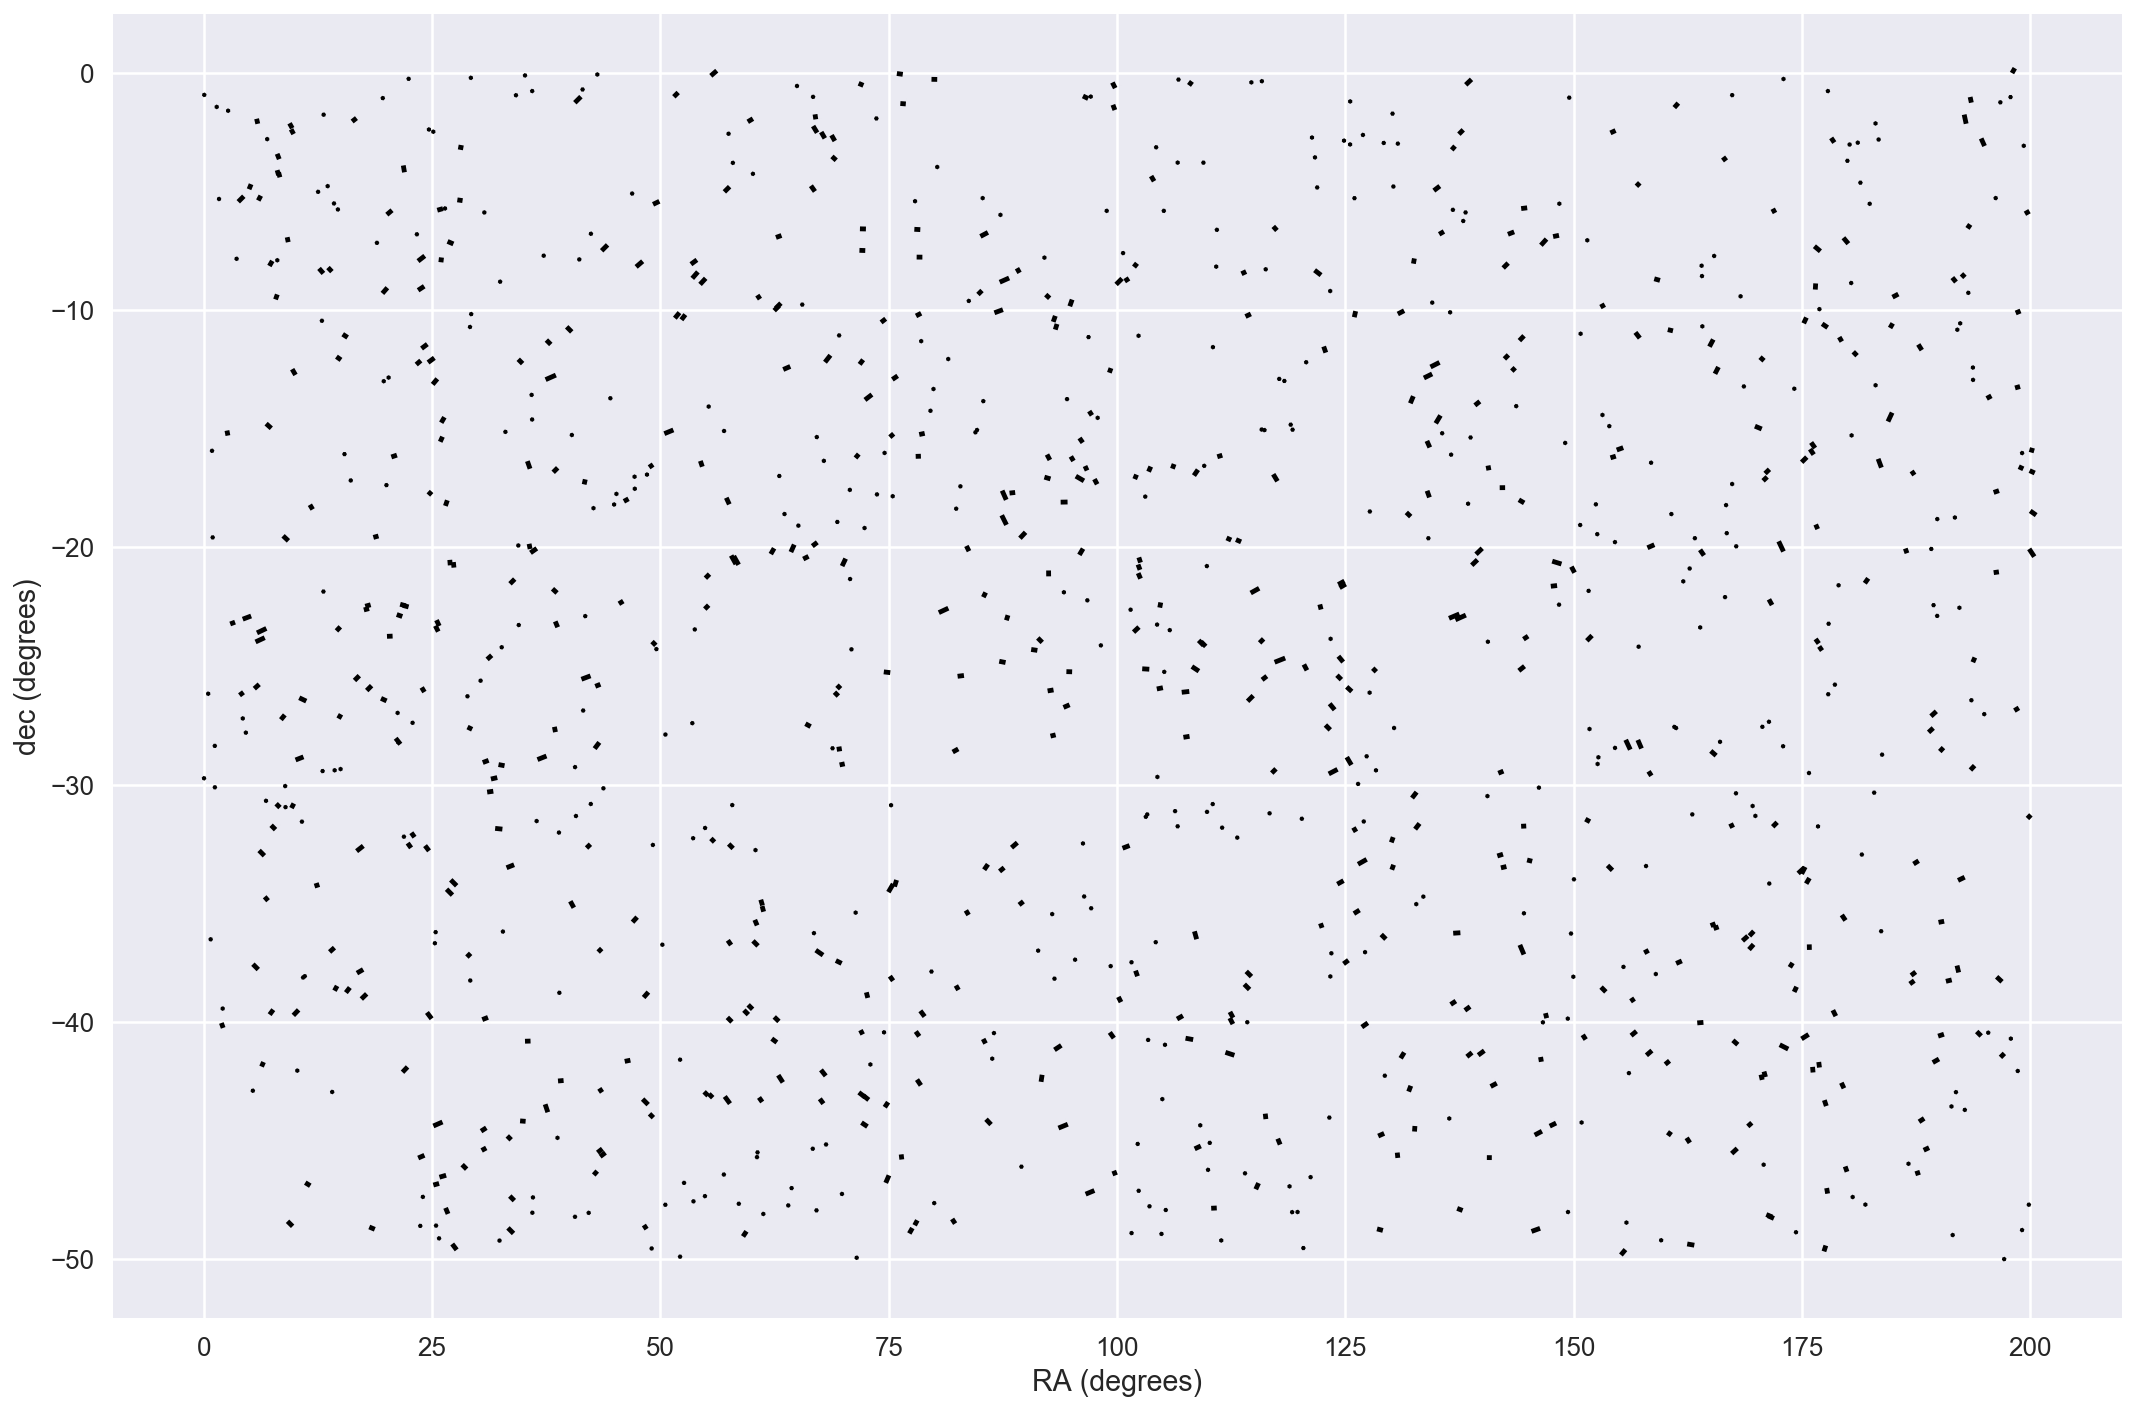

In [63]:
X = np.array(best_case.DELTA.e.keys())[:,0]
Y = np.array(best_case.DELTA.e.keys())[:,1]
e1 = np.array(best_case.DELTA.e.values())[:,0]
e2 = np.array(best_case.DELTA.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
#qk = plt.quiverkey(Q, 0.8, 0.85, 0.05, r'$|e|=0.05$', labelpos='E', coordinates='figure')

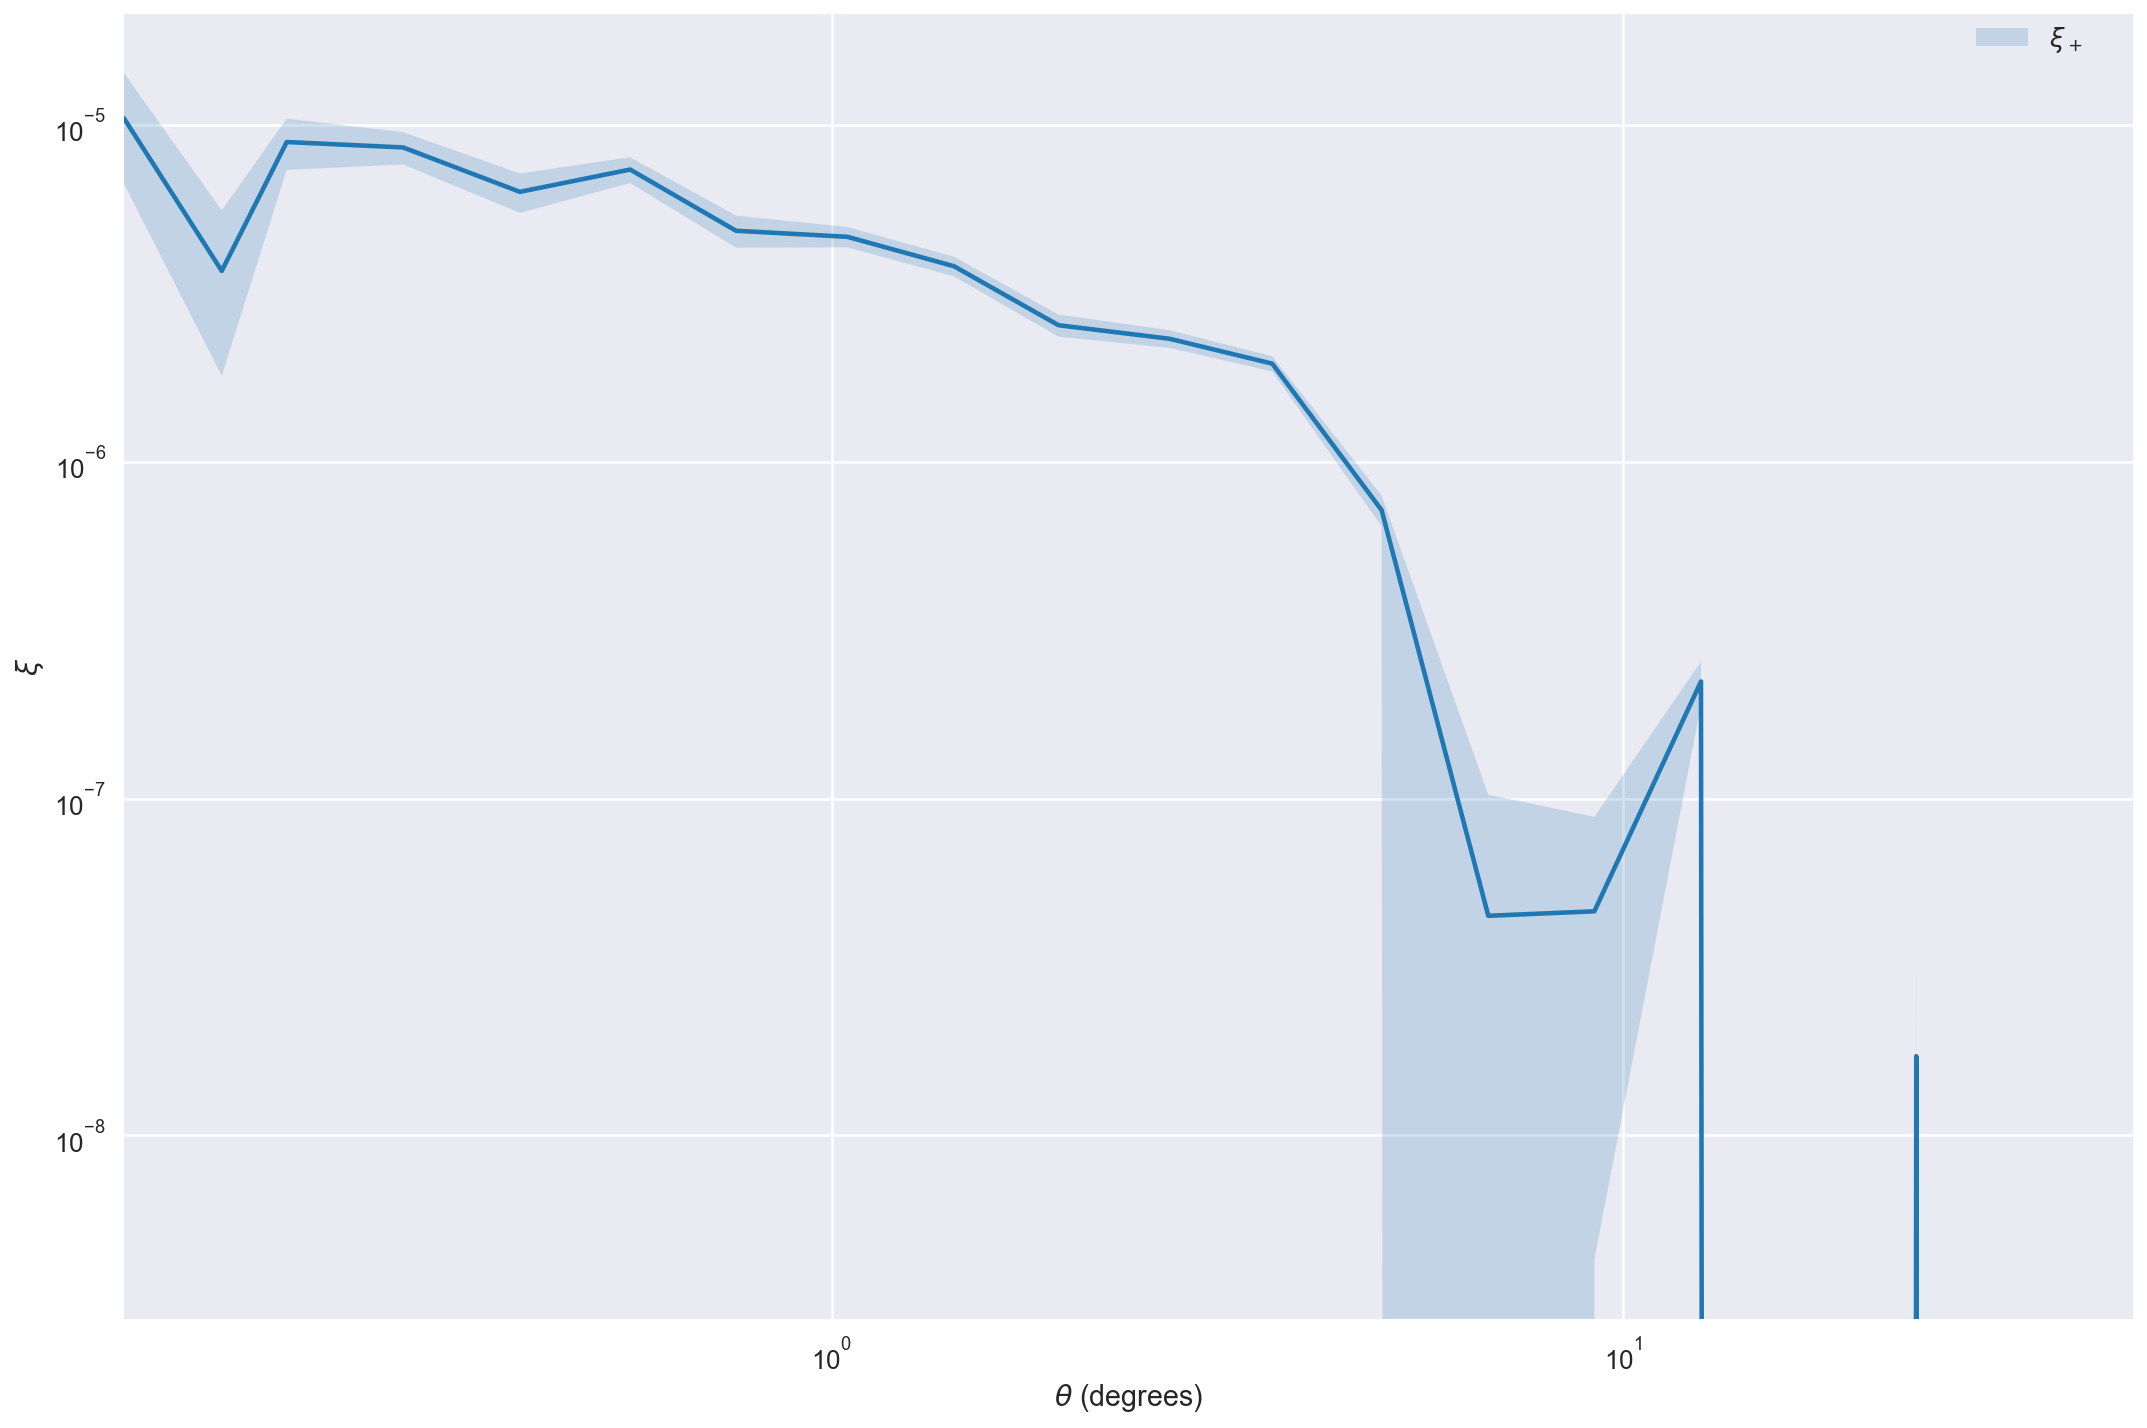

In [64]:
import treecorr
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
import seaborn.timeseries

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')
#sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [65]:
# 2 kinds of plots, one with rhos for y1 and one for y10, and one for both years for the same statisticsx

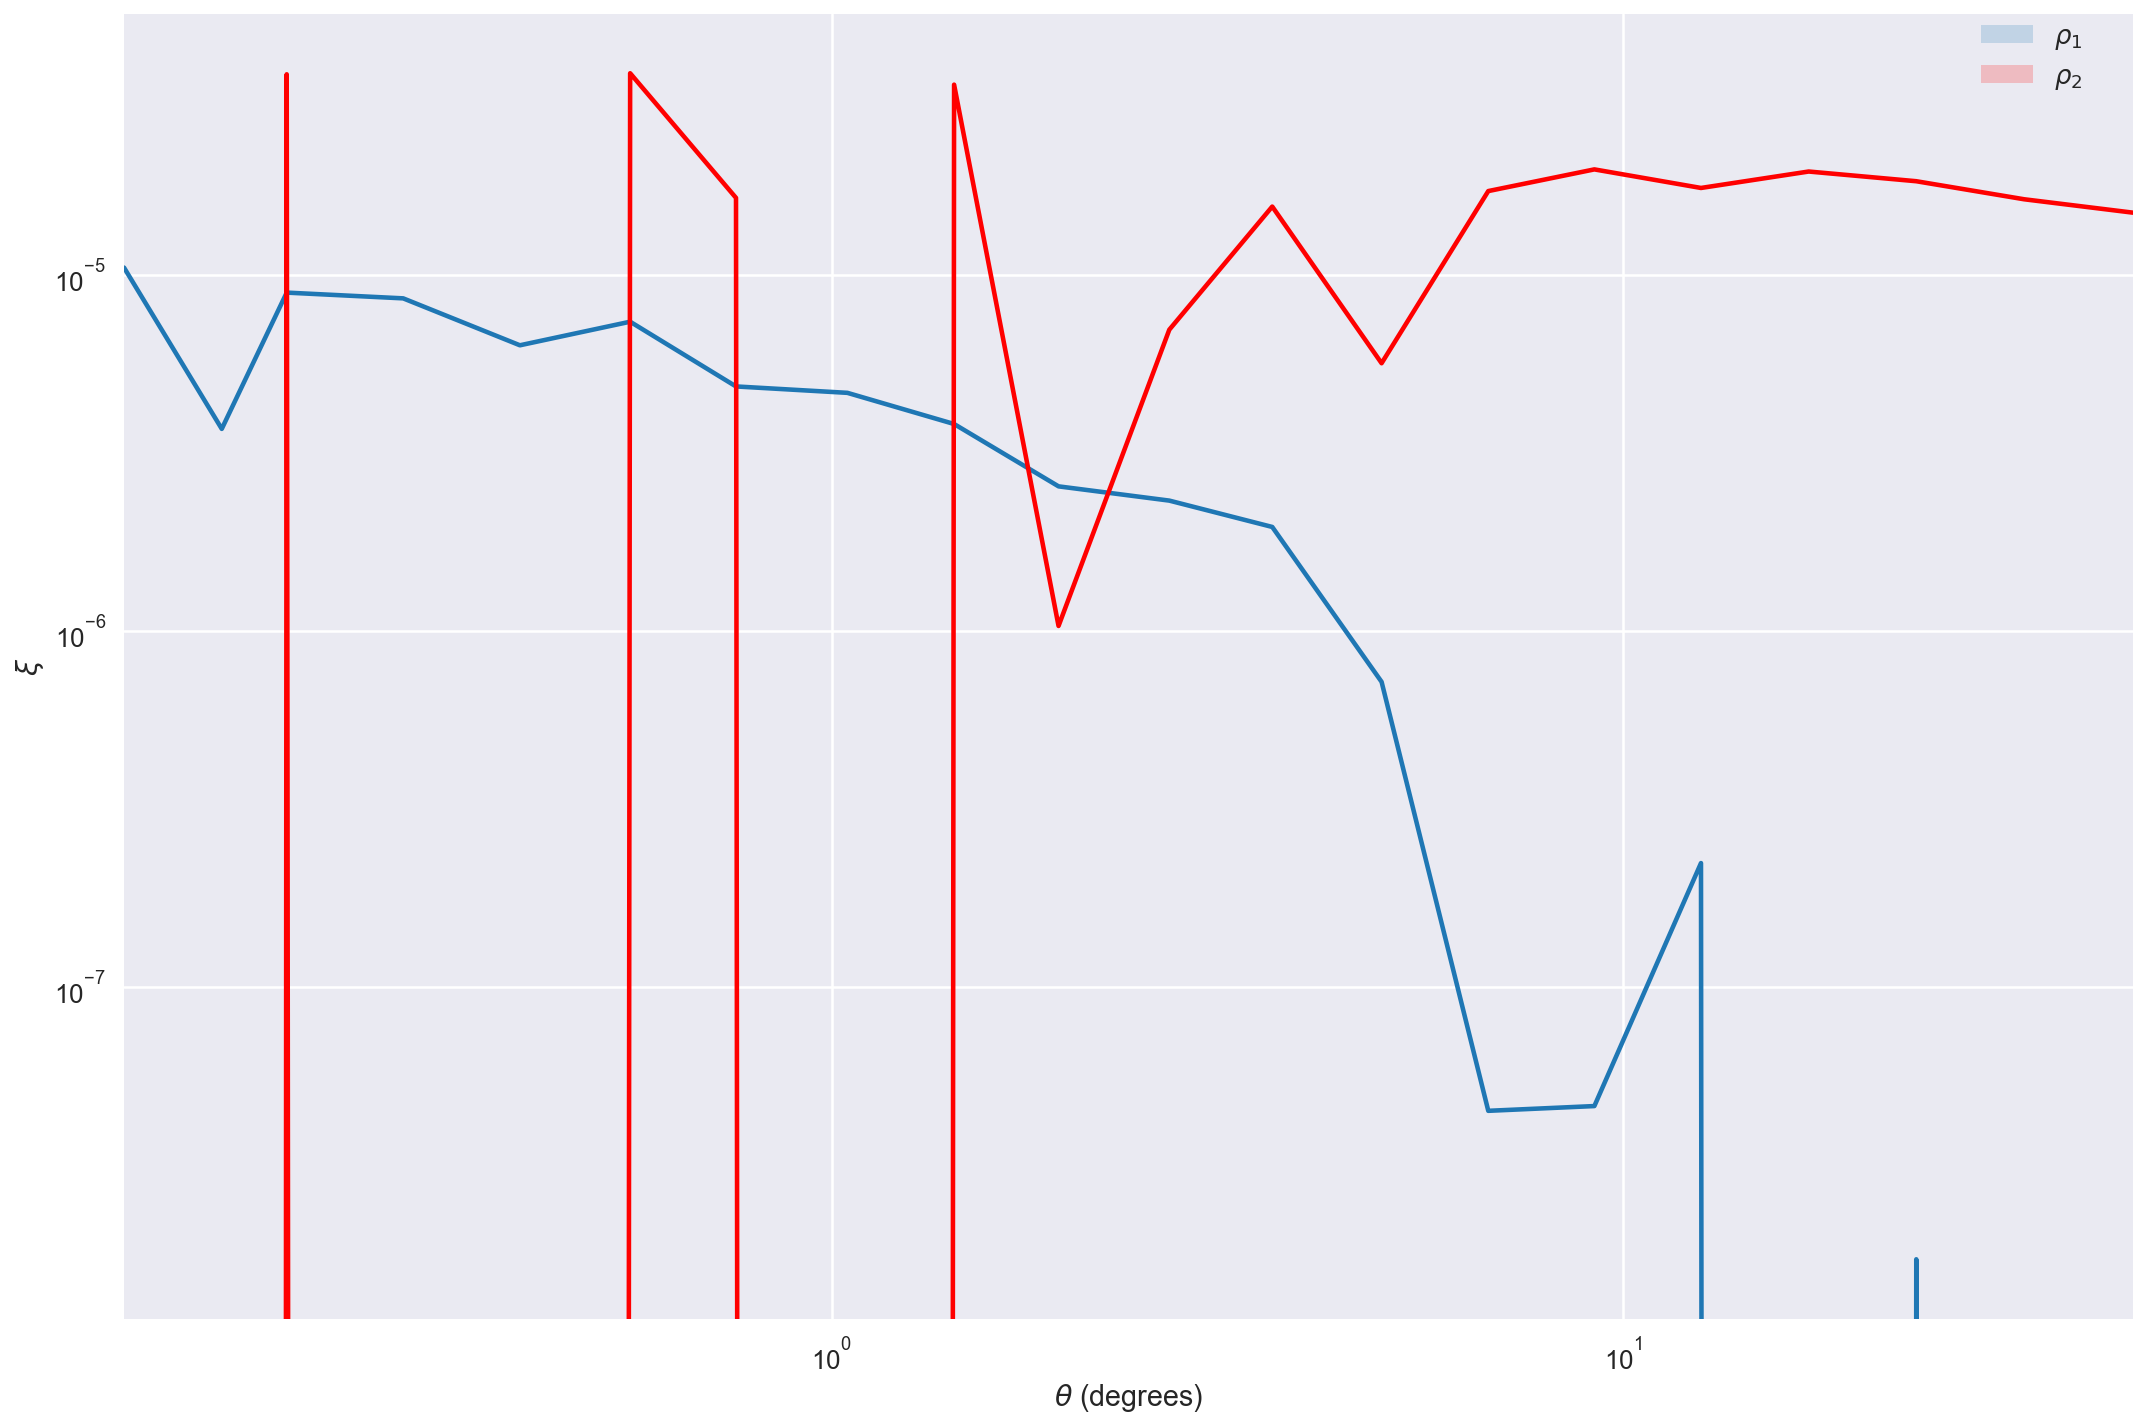

In [66]:
# def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
#     std = best_case.dede_sigma
#     ci = np.asarray((central_data - std, central_data + std))
#     kwargs.update({"central_data": central_data, "ci": ci, "data": data})
#     seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(best_case.rho1,best_case.r)#,err_style='std_bars')
sns.tsplot(best_case.rho2,best_case.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [76]:
y1 = ModelErrors('radial',WorstCase=False)

In [77]:
y1.getPositions(sqlWhere='filter = "r" and night < 365 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

In [78]:
y1.getModels()

In [79]:
y1.avgOver()

In [80]:
y1.M2e()

In [81]:
y1.getRhos()

TypeError: unsupported operand type(s) for *: 'Catalog' and 'float'

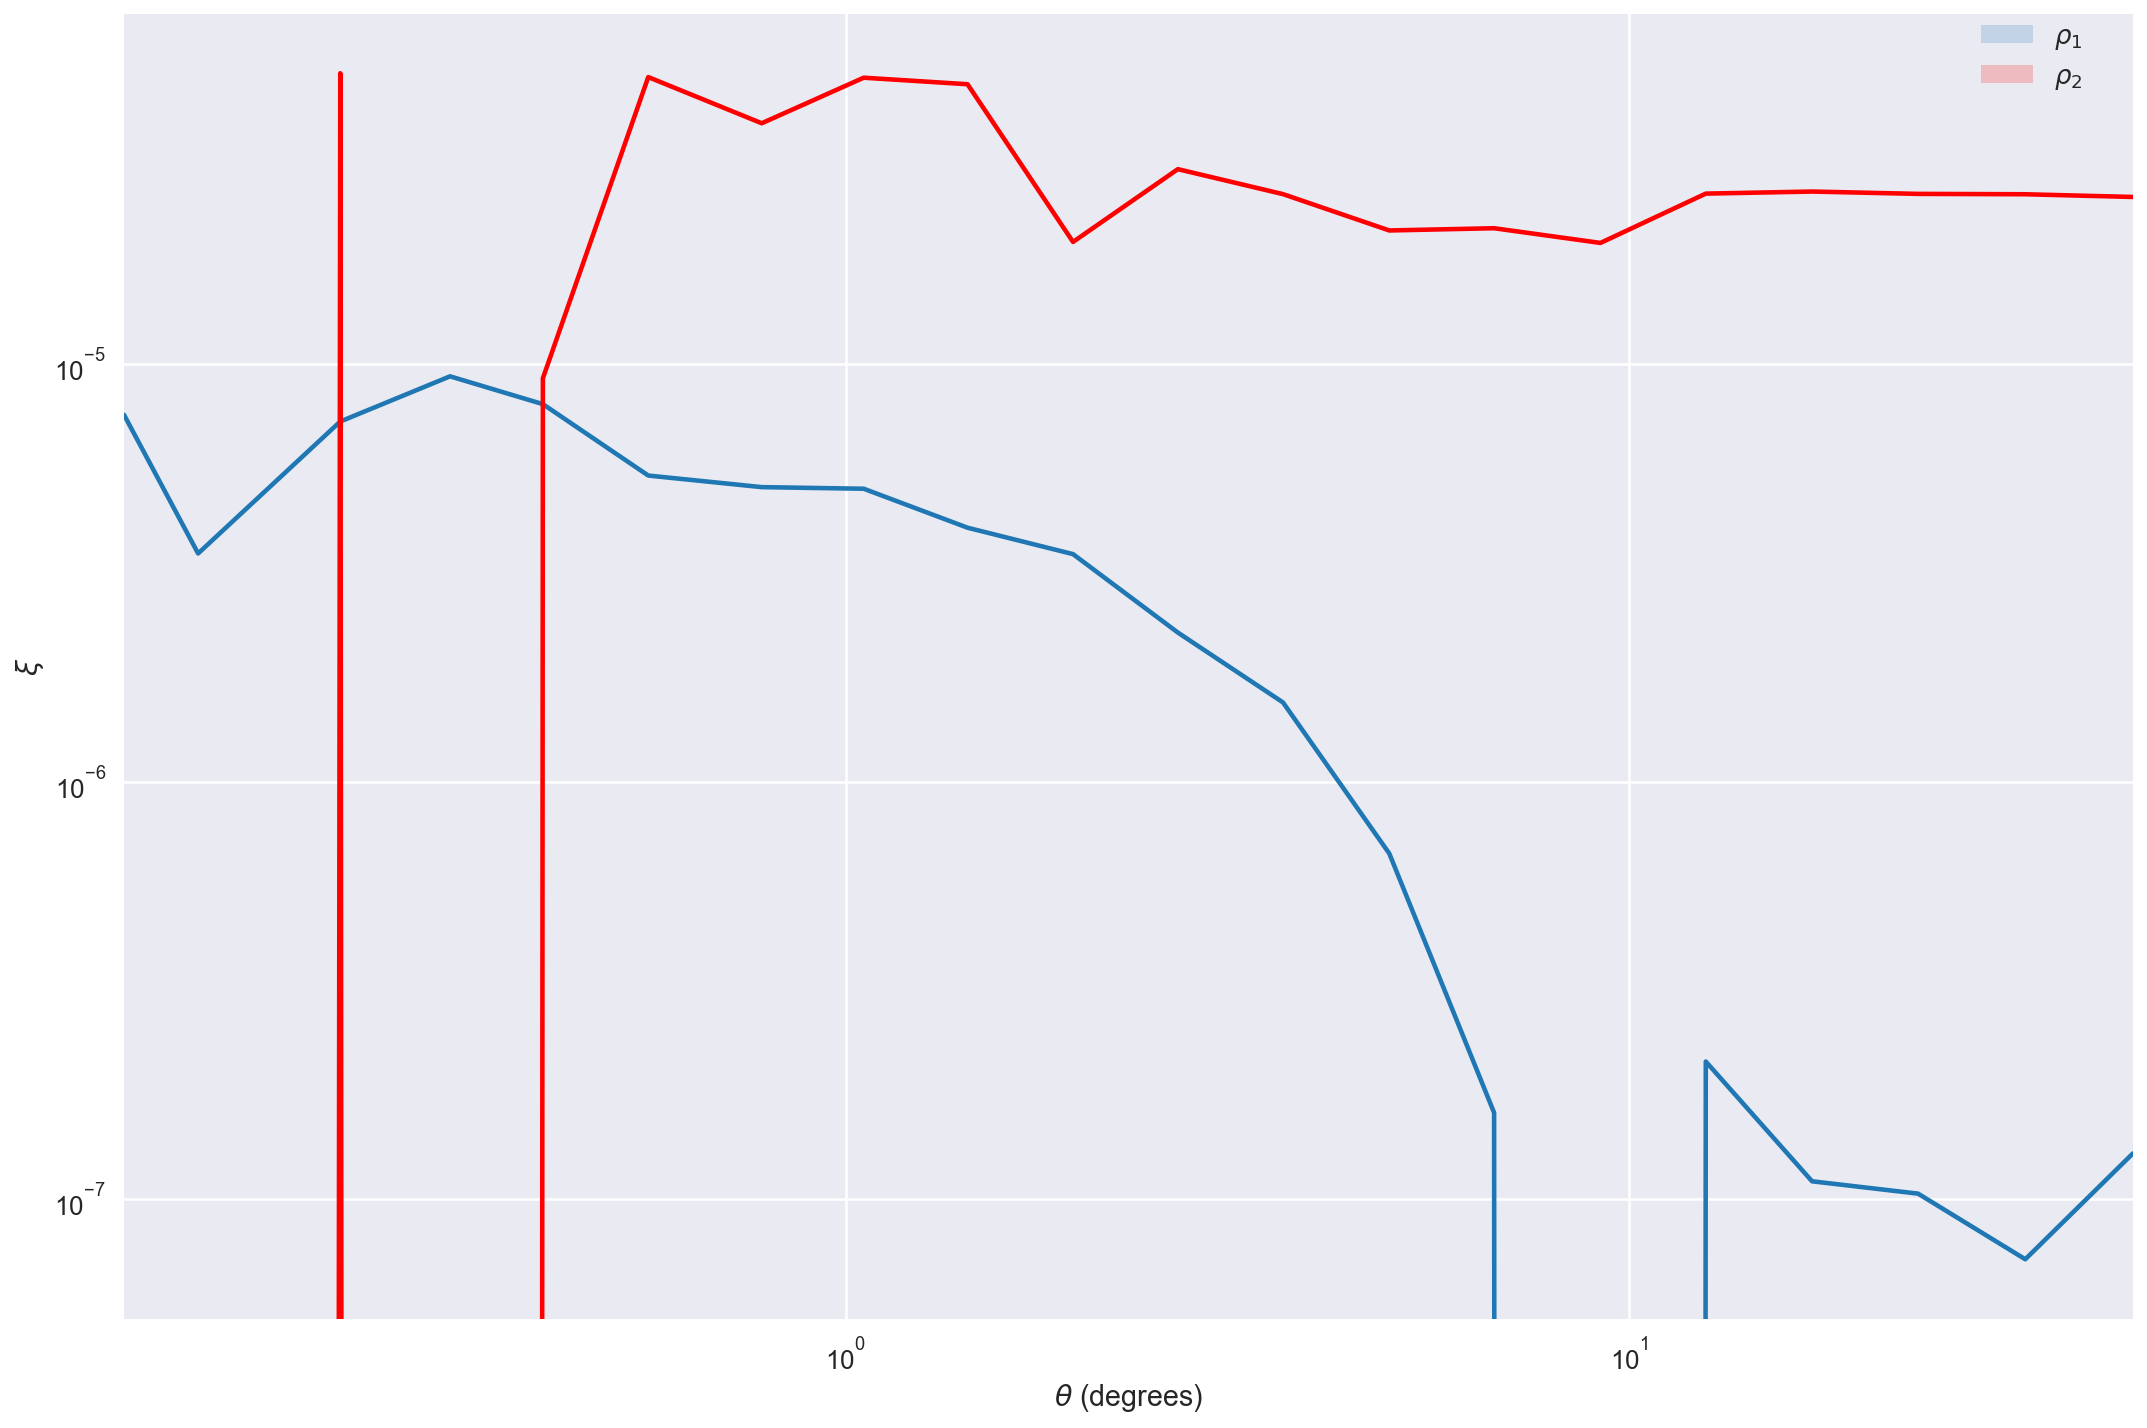

In [84]:
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(y1.rho2,y1.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

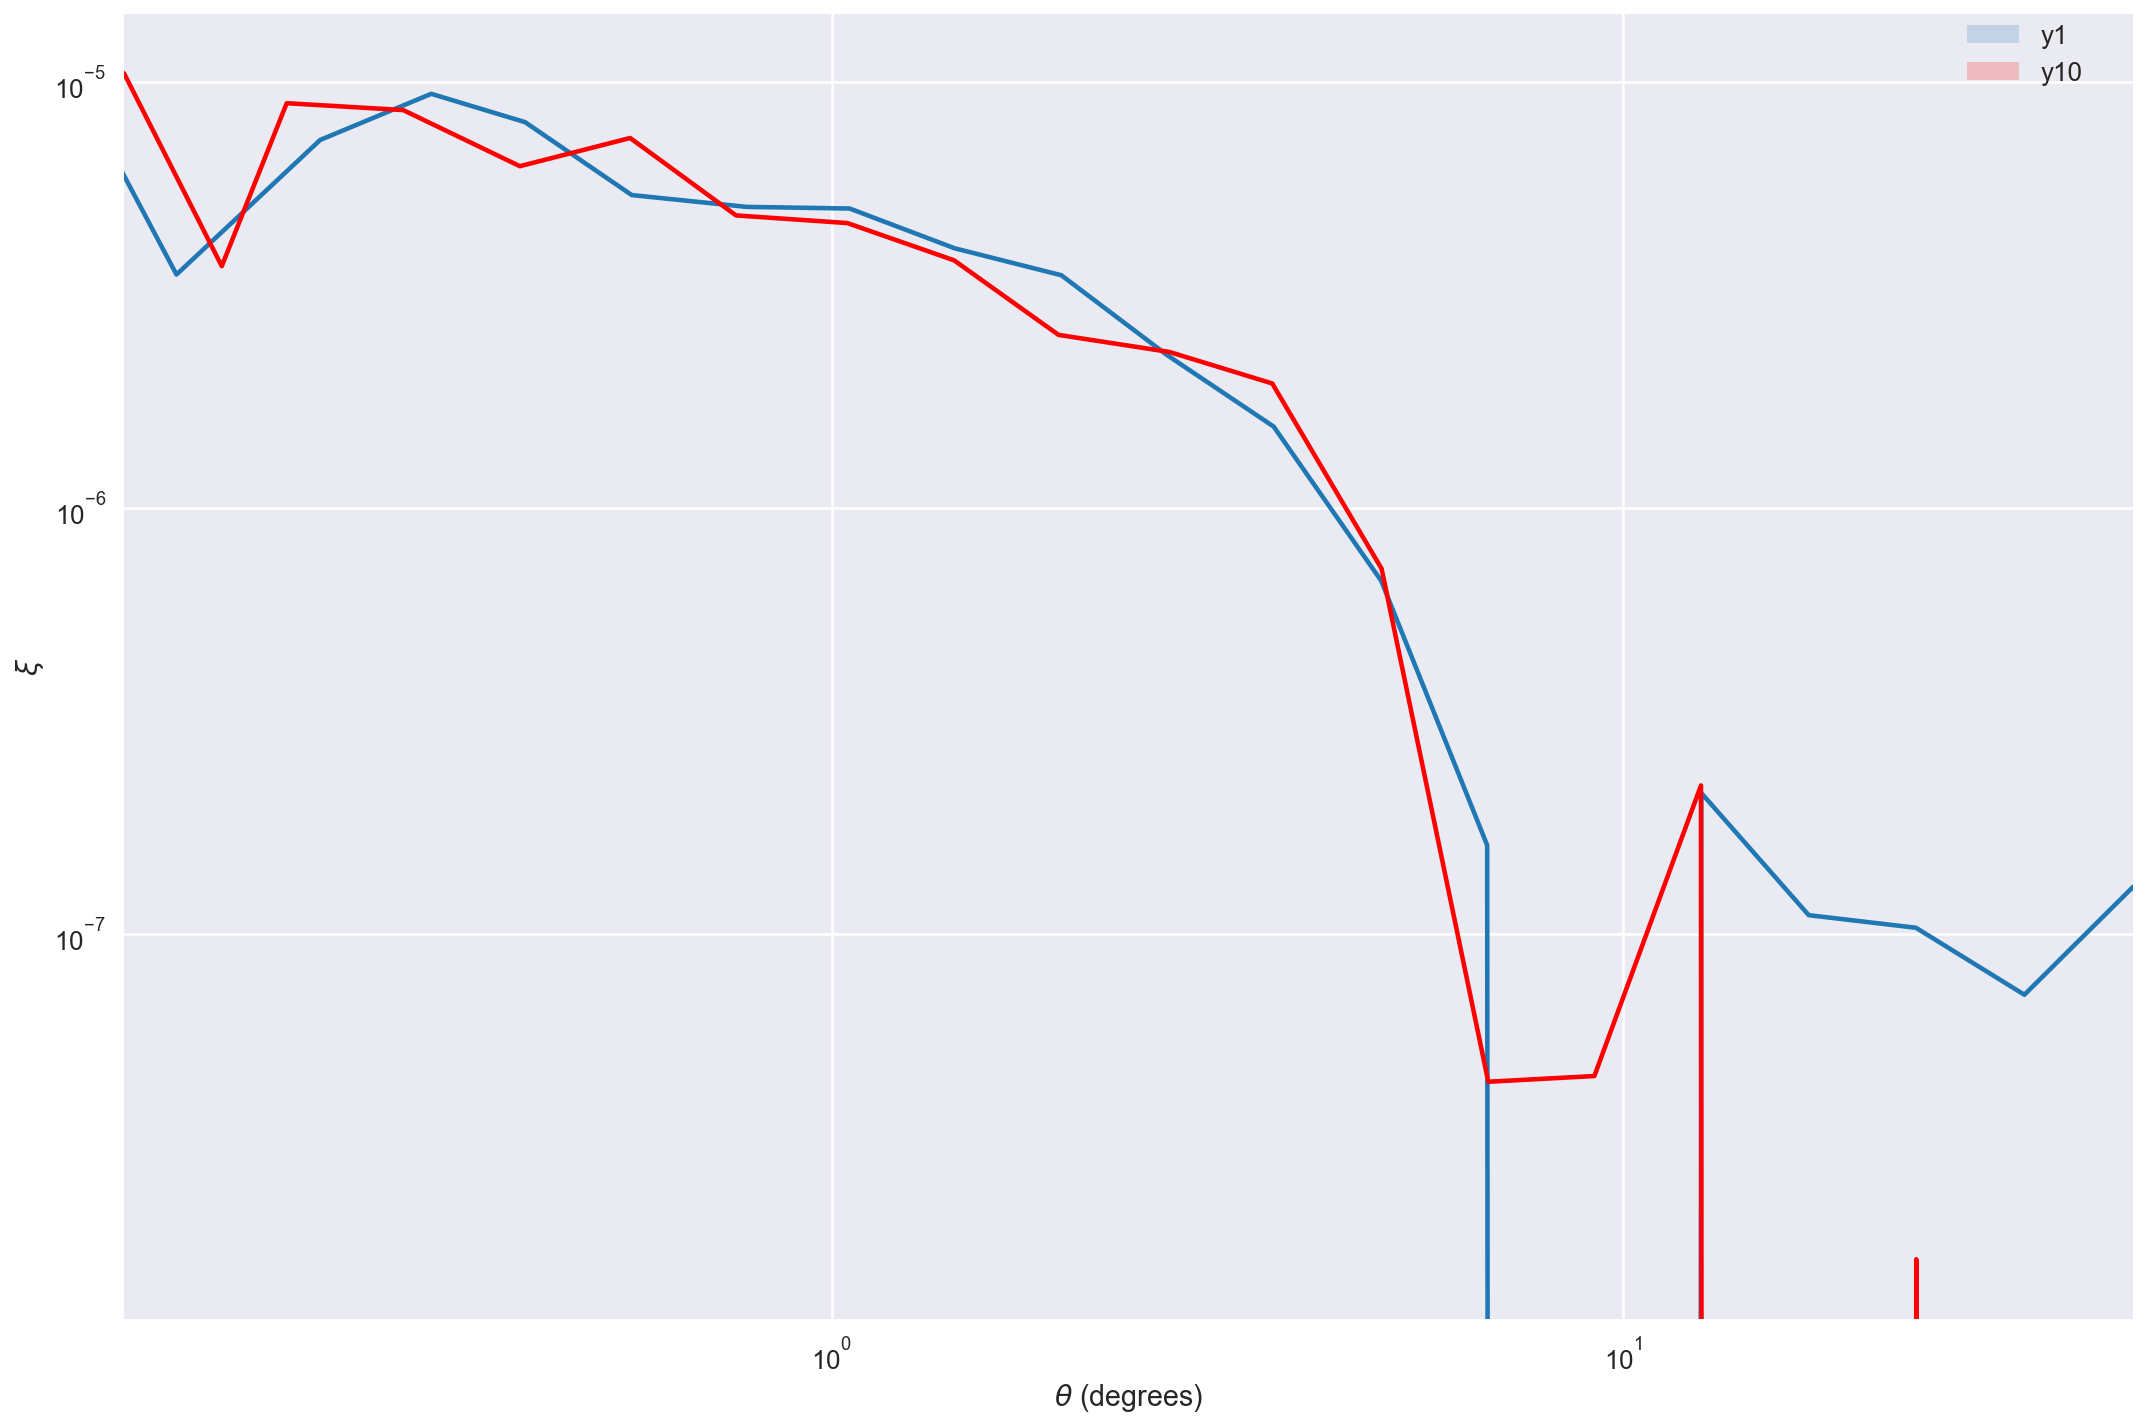

In [85]:
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(best_case.rho1,best_case.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'y1',r'y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)